## Data processing

This notebook provides a code for basic manipulation of the QFlow lite dataset. It allows to preview the simulated data (Step 2) and to convert the full NumPy files to `.csv` format (Step 3). 

### Step 0: Loading the necessary packages

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob
import os

### Step 1: Previewing the data

The followind code assumes that the data file to be previewd is in the same folder as the current notebook. The sample data file (`sample_data.npy`) has the following structure: 

* `dat.keys() = dict_keys(['physics', 'output', 'V_P2_vec', 'type', 'V_P1_vec'])`
    * `dat['physics']` -- setup of the device stored as dictionary
    * `dat['output']` -- output from the simulation stored as a list (100 $\times$ 100 elements); each element in `data['output']` is a distionary with keys: 
       
       `dat['output'][i].keys() = dict_keys(['state', 'charge', 'sensor', 'current'])`

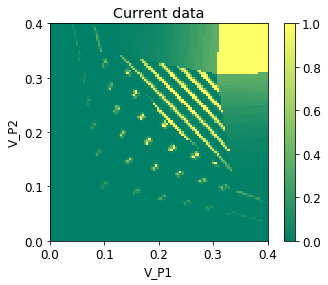

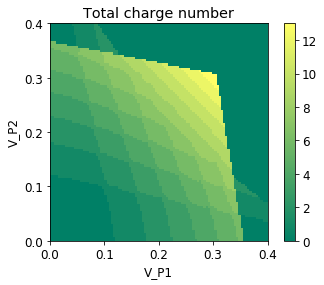

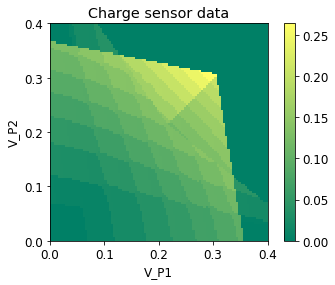

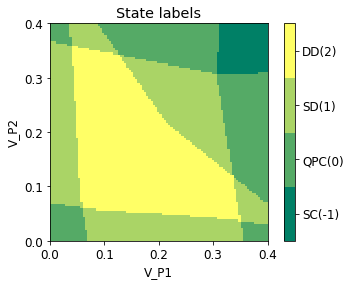

In [17]:
files = glob.glob(os.getcwd()+"/Data/"+"sample_file.npy")
dat = np.load(files[0]).item() 

V_P1 = -dat['V_P1_vec']
V_P2 = -dat['V_P2_vec']
X,Y=np.meshgrid(V_P1,V_P2)
N_v = 100

current_vec = np.array([x['current'] for x in dat['output']]).reshape(N_v,N_v)
charge_vec = np.array([np.sum(x['charge']) for x in dat['output']]).reshape(N_v,N_v)
state_vec = np.array([x['state'] for x in dat['output']]).reshape(N_v,N_v)
sensor_vec = np.array([x['sensor'] for x in dat['output']]).reshape(N_v,N_v,-1)[:,:,0]

matplotlib.rcParams.update({'font.size': 12})

y = [0.0,0.1,0.2,0.3,0.4]
plt.figure(1)
plt.axes().set_aspect('equal')
plt.title('Current data')
plt.xlabel("V_P1")
plt.ylabel("V_P2")
plt.pcolor(X,Y,current_vec,vmax=1e-4,cmap=cm.summer)
plt.yticks(np.arange(0.0, 0.5, 0.1))
bar = plt.colorbar()
bar.ax.set_yticklabels(['0.0', '0.2', '0.4','0.6', '0.8', '1.0'])
plt.show()

plt.figure(2)
plt.axes().set_aspect('equal')
plt.title('Total charge number')
plt.xlabel("V_P1")
plt.ylabel("V_P2")
plt.pcolor(X,Y,charge_vec,cmap=cm.summer)
plt.yticks(np.arange(0.0, 0.5, 0.1))
bar = plt.colorbar() 
plt.show()
    
plt.figure(3)
plt.axes().set_aspect('equal')
plt.title('Charge sensor data')
plt.xlabel("V_P1")
plt.ylabel("V_P2")
plt.pcolor(X,Y,sensor_vec,cmap=cm.summer)
plt.yticks(np.arange(0.0, 0.5, 0.1))
bar = plt.colorbar() 
plt.show()

plt.figure(4)
plt.axes().set_aspect('equal')
plt.title('State labels')
plt.xlabel("V_P1")
plt.ylabel("V_P2")
plt.pcolor(X,Y,state_vec,cmap=plt.cm.get_cmap('summer', 4))
plt.yticks(np.arange(0.0, 0.5, 0.1))
bar = plt.colorbar(ticks = [-1,0,1,2])
plt.clim(-1.5, 2.5)
bar.ax.set_yticklabels(['SC(-1)', 'QPC(0)', 'SD(1)','DD(2)'])
plt.show()


### Step 2: Creating a sample file

Converting the sample `*.npy` data file to `.csv` for easier preview. 

In [20]:
import csv

files = glob.glob(os.getcwd()+"/Data/"+"sample_file.npy")
dat = np.load(files[0]).item() 
data_dict = dat['output']
 
data = {"'V_P1": np.repeat(dat['V_P1_vec'], len(dat['V_P1_vec'])),
        "'V_P2": np.tile(dat['V_P2_vec'], len(dat['V_P2_vec'])),         
        "current": np.array([np.sum(x['current']) for x in dat['output']]),
        "charge": np.array([np.sum(x['charge']) for x in dat['output']]),
        "sensor": np.array([np.sum(x['sensor']) for x in dat['output']]),
        "state": np.array([np.sum(x['state']) for x in dat['output']])}

with open("Data/sample_data.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(data.keys())
    writer.writerows(zip(*data.values()))